# Mask R-CNN training script
The code was forked from https://github.com/matterport/Mask_RCNN and revised following https://github.com/uf-aiaos/ShinyAnimalCV



################################################################################################
#### Python=3.9
conda create --name BW  
conda install python=3.9  
pip install tensorflow-macos  
pip install tensorflow-metal   
pip install pandas  
pip install -U scikit-learn  

#### Python=3.10
Follow this page to install tensorflow with python=3.10  
https://github.com/jeffheaton/t81_558_deep_learning/blob/master/install/tensorflow-install-mac-metal-jan-2023.ipynb  


In [1]:
# What version of Python do you have?
import sys
import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import platform

print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python Platform: macOS-13.3.1-arm64-arm-64bit
Tensor Flow Version: 2.9.0
Keras Version: 2.9.0

Python 3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:38:11) 
[Clang 14.0.6 ]
Pandas 2.0.1
Scikit-Learn 1.2.2
GPU is available


In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 8.6 gigabytes of available RAM

Not using a high-RAM runtime


### Install dependencies

In [ ]:
!pip install imgaug
!pip install Cython
!pip install pycocotools
!pip install kaggle
!pip install h5py 
!pip install -U scikit-image 
!pip install gast
!pip install pyyaml


### Clone Mask RCNN github files.

In [3]:
#import dependencies 
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import yaml
from PIL import Image
import imgaug  

# Root directory of the project
# We suggested to use the mrcnn in our github. https://github.com/yebigithub/BW_dairy/tree/main/python/mrcnn/MaskRCNN_Train/mrcnn
ROOT_DIR = os.path.abspath("/Users/yebi/Library/CloudStorage/OneDrive-VirginiaTech/Research/Codes/research/BCS/BodyWeight/BW_github_beta/python/mrcnn/MaskRCNN_Train")

# Import Mask RCNN
sys.path.append(ROOT_DIR) 
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log 

%matplotlib inline 

## Configurations

In [4]:
class ShapesConfig(Config):
    """Configuration for training on the dataset.
    Derives from the base Config class and overrides values specific
    to the dataset.
    """
    # Give the configuration a recognizable name
    NAME = "cow"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    BACKBONE = "resnet50"

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1 # background + stem #

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 300 #100

    DETECTION_MIN_CONFIDENCE = 0.9
    IMAGE_MIN_DIM = 400

    # Set mini mask to false; It is TRUE in default config
    USE_MINI_MASK = False
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  400
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE          

## Notebook Preferences

## Dataset
Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [6]:
class CowDataset(utils.Dataset):
    # get the number of objects
    def get_obj_index(self, image):
        n = np.max(image)
        return n

    # interpret the yaml file 
    def from_yaml_get_class(self, image_id):
        info = self.image_info[image_id]
        with open(info['yaml_path']) as f:
            temp = yaml.full_load(f.read())
            labels = temp['label_names'] 
            del labels[0]
        return labels

    # 
    def draw_mask(self, num_obj, mask, image,image_id):
        info = self.image_info[image_id]
        for index in range(num_obj):
            for i in range(info['width']):
                for j in range(info['height']):
                    at_pixel = image.getpixel((i, j))
                    if at_pixel == index + 1:
                        mask[j, i, index] = 1
        return mask


    # add path、mask_path 、yaml_path to self.image_info
    def load_shapes(self, img_floder, mask_floder, dataset_root_path):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("shapes", 1, "cow")
        imglist = os.listdir(img_floder)

        for i in range(0, len(imglist)):
            filestr = imglist[i].split(".")[0]
            if len(filestr)==0:
                pass
            else:
                mask_path = mask_floder + "/" + filestr + "_json/" + "label.png"
                yaml_path = mask_floder + "/" + filestr + "_json/info.yaml"
                cv_img = cv2.imread(img_floder + "/" + filestr + ".png")
                print('cv_img: ', i, img_floder + "/" + filestr + ".png")
                self.add_image("shapes", image_id=i, path=img_floder + "/" + imglist[i],
                                width=cv_img.shape[1], height=cv_img.shape[0], mask_path=mask_path, yaml_path=yaml_path)

    def load_mask(self, image_id):
        '''
        Generate instance masks for shapes of the given image ID.
        '''
        global iter_num
        print("image_id",image_id)
        info = self.image_info[image_id]
        count = 1  # number of object
        img = Image.open(info['mask_path'])
        num_obj = self.get_obj_index(img)
        mask = np.zeros([info['height'], info['width'], num_obj], dtype=np.uint8)
        mask = self.draw_mask(num_obj, mask, img,image_id)
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count - 2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion

            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        labels = []
        labels = self.from_yaml_get_class(image_id)
        labels_form = []
        for i in range(len(labels)):
            if labels[i].find("cow") != -1:
                labels_form.append("cow")
        class_ids = np.array([self.class_names.index(s) for s in labels_form])
        return mask, class_ids.astype(np.int32)

def get_ax(rows=1, cols=1, size=8):
    '''
    Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    Change the default size attribute to control the size
    of rendered images
    '''
    _, ax = plt.subplots(rows, cols, figsize=(size * cols, size * rows))
    return ax

In [7]:
# set dataset root path
dataset_root_path=os.path.abspath("/Users/yebi/Library/CloudStorage/OneDrive-VirginiaTech/Research/Codes/research/BCS/BodyWeight/MaskRCNN_training/images/dataset") +"/"
print(os.listdir(dataset_root_path))

# set the path to train, validationl, and test images
img_train_floder = dataset_root_path + "pic_train"
img_val_floder = dataset_root_path + "pic_val"
img_test_floder = dataset_root_path + "pic_test"
mask_floder = dataset_root_path + "cv2_mask"


['.DS_Store', 'cv2_mask', 'pic_test', 'pic_val', 'pic_train']


In [44]:
#load training dataset
print("train dataset")
dataset_train = CowDataset()
dataset_train.load_shapes(img_train_floder, mask_floder, dataset_root_path)
dataset_train.prepare()

#load validation dataset
print("validation dataset")
dataset_val = CowDataset()
dataset_val.load_shapes(img_val_floder, mask_floder, dataset_root_path)
dataset_val.prepare()

#load test dataset
print("test dataset")
dataset_test = CowDataset()
dataset_test.load_shapes(img_test_floder, mask_floder, dataset_root_path)
dataset_test.prepare()

train dataset
cv_img:  0 /Users/yebi/Library/CloudStorage/OneDrive-VirginiaTech/Research/Codes/research/BCS/BodyWeight/MaskRCNN_training/images/dataset/pic_train/5327AM_Depth_2768.png
cv_img:  1 /Users/yebi/Library/CloudStorage/OneDrive-VirginiaTech/Research/Codes/research/BCS/BodyWeight/MaskRCNN_training/images/dataset/pic_train/5422AM_Depth_27129.png
cv_img:  2 /Users/yebi/Library/CloudStorage/OneDrive-VirginiaTech/Research/Codes/research/BCS/BodyWeight/MaskRCNN_training/images/dataset/pic_train/5327AM_Depth_15162.png
cv_img:  3 /Users/yebi/Library/CloudStorage/OneDrive-VirginiaTech/Research/Codes/research/BCS/BodyWeight/MaskRCNN_training/images/dataset/pic_train/5147AM_Depth_27360.png
cv_img:  4 /Users/yebi/Library/CloudStorage/OneDrive-VirginiaTech/Research/Codes/research/BCS/BodyWeight/MaskRCNN_training/images/dataset/pic_train/5422AM_Depth_8698.png
cv_img:  5 /Users/yebi/Library/CloudStorage/OneDrive-VirginiaTech/Research/Codes/research/BCS/BodyWeight/MaskRCNN_training/images/dat

[1]
image_id 1


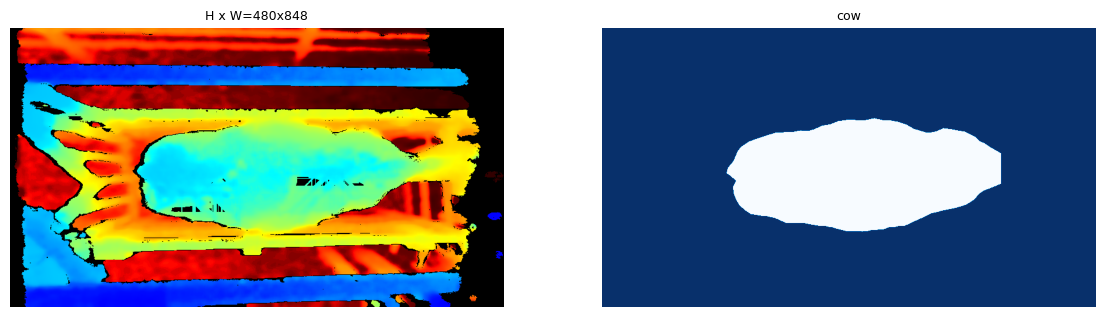

['BG', 'cow']


In [9]:
# Load and display random samples
image_ids = [1]    

print(image_ids)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names, limit=1)

    print(dataset_train.class_names)

## Ceate Model

In [11]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)
# Create model in training mode


In [ ]:
model = modellib.MaskRCNN(mode ="training", config = config, model_dir = MODEL_DIR) 

In [ ]:
# Which weights to start with?
# init_with = "last"  # coco, or last

init_with = "coco" 

if init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
#     model.load_weights(COCO_MODEL_PATH, by_name=True)

elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

  # the trained weights will be saved in the folder logs

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [ ]:
# Training - Stage 1
# Train heads of mrcnn.
print("Training network heads")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=35,
            layers='heads'
            #augmentation=augmentation
            )


In [ ]:
# Training - Stage 2
# Finetune layers from ResNet stage 4 and up
print("Fine tune Resnet stage 4 and up")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=40,
            layers='4+'
            #augmentation=augmentation
            )


In [ ]:
# Training - Stage 3
print("Fine tune all layers")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE / 5,
            epochs=50,
            layers='all'
            #augmentation=augmentation
            )

print("finished training")

## Detection

In [ ]:
# set configurations 
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.3
    USE_MINI_MASK = False

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

model_path = "/Users/yebi/Library/CloudStorage/OneDrive-VirginiaTech/Research/Codes/research/BCS/BodyWeight/MaskRCNN_training/MaskRCNN_Code/mask_rcnn_cow.h5"
# Load trained weights
print("Loading weights from ", model_path)


In [ ]:
tf.keras.Model.load_weights(model.keras_model, model_path, by_name=True)

image_id 36
image ID: shapes.37 (36) 
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  317.00000  max:  743.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  uint8


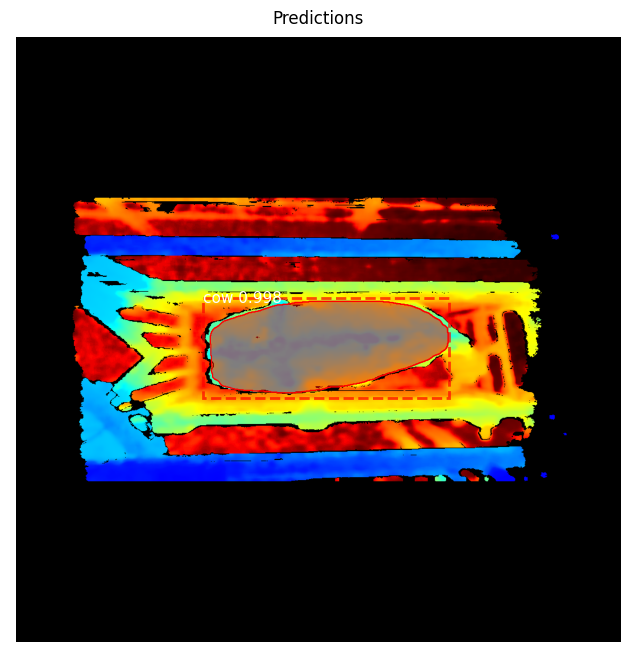

In [45]:
image_id = 36
# image_id = random.choice(dataset_test.image_ids)

image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_test, inference_config, image_id)
info = dataset_test.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset_test.image_reference(image_id)))

results = model.detect([image], verbose=0)

ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_test.class_names, r['scores'], ax=ax,
                            title="Predictions")

log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

In [48]:
scores = []
for image_id in dataset_train.image_ids:
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_test, inference_config, image_id)
    results = model.detect([image], verbose=0)
    r = results[0]
    scores.append(r['scores'])


image_id 55


In [49]:
np.mean(scores)

0.9979891